# INTRODUCTION TO EXPLAINABLE AI

In this notebook, two main concepts are introduced:
1) SHAP (SHapley Additive exPlanations) for explaining predictions (using a simple tabular example).
2) Attention U-Net for medical image segmentation using MONAI, which also brings some interpretability via attention maps.

This notebook should take about 30-45 minutes to run through and is designed to give you an introductory-level understanding of explainable AI in two different contexts. Chunks of code are provided and other parts are omitted. Students are required to complete these omitted sections.

## Part 1: Explaining Models with SHAP

SHAP is a popular library for explainability in machine learning models.
It computes "Shapley values" which measure how much each feature in a single prediction contributes to pushing the model's output away from some baseline prediction.

We'll do a quick demonstration with a tabular dataset (a small data example).
The approach here is inspired by the Kaggle tutorials:
- https://www.kaggle.com/code/dansbecker/shap-values
- https://www.kaggle.com/code/dansbecker/advanced-uses-of-shap-values

In [ ]:
!pip install shap -q

In [ ]:
# TODO: Import necessary libraries for this part
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import fetch_california_housing
import shap

data_cal = fetch_california_housing()
X = pd.DataFrame(data_cal['data'], columns=data_cal['feature_names'])
y = pd.Series(data_cal['target'], name='MedHouseVal')

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Train a RandomForest for demonstration
# TODO: Create and fit a Random Forest model with 50 estimators
model = RandomForestRegressor(n_estimators=50, random_state=42)
model.fit(X_train, y_train)

print(f"Model training complete. R^2 on test set: {model.score(X_test, y_test):.2f}")

Model training complete. R^2 on test set: 0.81


In [ ]:
# Create SHAP explainer
# TODO: Initialize SHAP explainer with the trained model
# Calculate SHAP values for test data
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

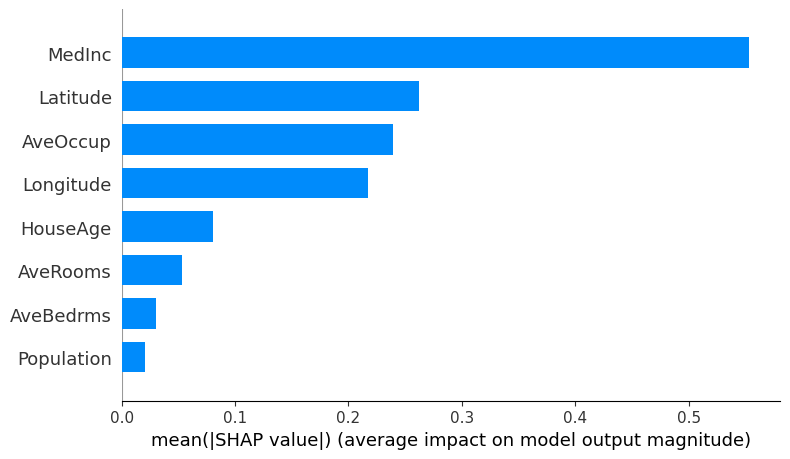

In [ ]:
# Summarize the importance of each feature for predictions in the test set
# TODO: Create a shap bar plot that ranks the most important to least important feature
shap.summary_plot(shap_values, X_test, plot_type='bar', max_display=10)

### Interpretation
As seen in the bar plot of SHAP values, `Median Income` was the most important feature in predicting median house price. Next, location of the house, indicated by `Latitude` and `Longitude`, was the second most important factor in predicting house price. Finally, Average occupation was the third most important feature.

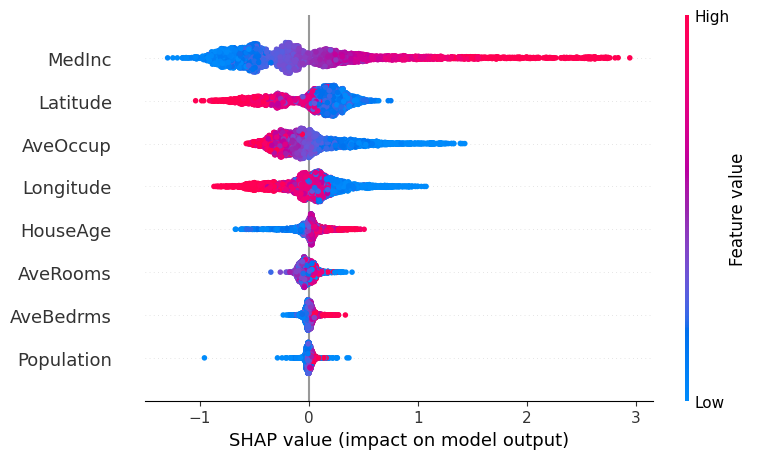

In [ ]:
# A more detailed summary plot
# TODO: Create the default SHAP plot (hint: how can you change the previous line of code to create an image
# like the one shown below)
shap.summary_plot(shap_values, X_test)

### Interpretation
- High values of Median Income resulted in high house prices.
- Houses situated in lower longitude and lattitude were more expensive.
- Similarly, houses with low average occupation were more expensive.
- Older houses are shown to be more expensive.

In [ ]:
# Let's pick one row of data and explain that single prediction
row_to_show = 5
data_for_prediction = X_test.iloc[row_to_show]
# We create an explainer specifically for that row
shap_explanation = explainer.shap_values(data_for_prediction)

# Force plot for a single observation
shap.initjs()
shap.force_plot(explainer.expected_value, shap_explanation, data_for_prediction)

### Interpretation
- The base prediction was $2.071$, but the prediction for this specific data was $1.69.$
- `Population`, `Latitude`, and `MedInc` are the features that pushed the prediction to the higher than the base value.
- On the other hand, `Longitude=-117.6`, `HouseAge=12`, `AverageOccup=2.847`, `AveRooms=5.251`, and `AveBedrms=0.9751` are the features and their values that pushed the prediction to the lower than the base value.

In this section you:
1) Train a simple model
2) Use shap.TreeExplainer
3) Summarize global feature importance
4) Explain a single prediction with a force plot

Next, let's move on to a more advanced medical imaging example with MONAI and an Attention U-Net.


# Part 2: Attention U-Net with MONAI 3D Segmentation

In this section, we'll show a simplified pipeline to:
1) Download the Medical Segmentation Decathlon Spleen dataset
2) Define transforms, dataset, and dataloader
3) Create an Attention U-Net model
4) Train for a small number of epochs
5) Validate using Dice metric

Because we use an Attention U-Net, we have an "attention gate" mechanism which can help visualize *where* the model is focusing within the data. This is a form of interpretability or explainability in medical image analysis.

For more details, see:
- https://docs.monai.io/en/stable/
- https://monai.io/

In [ ]:
!pip install monai==0.9.1 nibabel tqdm -q

!pip install --upgrade "torch==1.11.0" "torchvision==0.12.0" -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 990.7/990.7 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 53.2 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement torch==1.11.0 (from versions: 1.13.0, 1.13.1, 2.0.0, 2.0.1, 

In [30]:
import os
import shutil
import glob
import tempfile
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
# TODO: Import necessary libraries for this part
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch
from typing import Optional
import numpy as np
from monai.transforms import Compose, Randomizable
from typing import Optional
import torch
import torch.nn as nn
import torch.optim as optim


from monai.transforms import (
    LoadImaged,
    AddChanneld,
    CropForegroundd,
    ScaleIntensityRanged,
    SpatialPadd,
    RandSpatialCropd,
    RandFlipd,
    RandRotate90d,
    RandZoomd,
    EnsureTyped,
    Compose,
    CenterSpatialCropd
)

from monai.data import CacheDataset, list_data_collate
from monai.networks.nets import AttentionUnet
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.config import print_config
from monai.inferers import sliding_window_inference
from monai.utils import get_seed
from monai.utils import MAX_SEED

print_config()

MONAI version: 0.9.1
Numpy version: 2.0.2
Pytorch version: 2.6.0+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 356d2d2f41b473f588899d705bbc682308cee52c
MONAI __file__: /usr/local/lib/python3.11/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.25.2
Pillow version: 11.1.0
Tensorboard version: 2.18.0
gdown version: 5.2.0
TorchVision version: 0.21.0+cu124
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.2.2
einops version: 0.8.1
transformers version: 4.49.0
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [ ]:
# Mount Google Drive to save data temporarily
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# Create a (temporary) directory for data
DATA_ROOT_DIR = "/content/drive/MyDrive/spleen_data"

# The Spleen dataset for the Medical Segmentation Decathlon
MSD_URL = "https://msd-for-monai.s3-us-west-2.amazonaws.com/"
SPLEN_DATASET_ZIP = "Task09_Spleen.tar"

# Download the dataset if not already present
if not os.path.exists(os.path.join(DATA_ROOT_DIR, "Task09_Spleen")):
    !wget -q {MSD_URL + SPLEN_DATASET_ZIP} -P {DATA_ROOT_DIR}
    !tar xf {os.path.join(DATA_ROOT_DIR, SPLEN_DATASET_ZIP)} -C {DATA_ROOT_DIR}
    print("Downloaded and extracted the Task09_Spleen dataset.")
else:
    print("MSD Spleen dataset already exists.")

import re

def get_spleen_index(fname):
    """
    Parse the file name to extract the numeric portion (e.g., 'spleen_10.nii.gz' -> 10).
    """
    base = os.path.basename(fname)
    match = re.search(r"spleen_(\d+)\.nii", base)
    return int(match.group(1)) if match else -1

# Gather all spleen_*.nii.gz in imagesTr and labelsTr
images_dir = os.path.join(DATA_ROOT_DIR, "Task09_Spleen/imagesTr")
labels_dir = os.path.join(DATA_ROOT_DIR, "Task09_Spleen/labelsTr")

image_files = sorted(glob.glob(os.path.join(images_dir, "spleen_*.nii.gz")), key=get_spleen_index)
label_files = sorted(glob.glob(os.path.join(labels_dir, "spleen_*.nii.gz")), key=get_spleen_index)

# Decide how many for training, how many for validation
training_images = image_files[:20]
training_labels = label_files[:20]
validation_images = image_files[20:30]
validation_labels = label_files[20:30]

# Build the data dictionary - very important to format correctly
train_data = [
    {"image": img, "label": lbl}
    for img, lbl in zip(training_images, training_labels)
]

val_data = [
    {"image": img, "label": lbl}
    for img, lbl in zip(validation_images, validation_labels)
]

print("Number of training files:", len(train_data))
print("Number of validation files:", len(val_data))

Downloaded and extracted the Task09_Spleen dataset.
Number of training files: 20
Number of validation files: 10


In [10]:
sample_image_path = train_data[0]["image"]
sample_image = nib.load(sample_image_path)
print(f"Original image shape: {sample_image.shape}")

# Find minimum dimension across all training images
min_dim = float('inf')
for data_item in train_data:
    img = nib.load(data_item["image"])
    shape = img.shape
    current_min = min(shape)
    if current_min < min_dim:
        min_dim = current_min
        min_shape = shape

print(f"Smallest dimension found: {min_dim}")
print(f"Shape with smallest dimension: {min_shape}")

Original image shape: (512, 512, 90)
Smallest dimension found: 31
Shape with smallest dimension: (512, 512, 31)


In [23]:
# Use a reasonable crop size based on the minimum dimension
crop_size = 32
print(f"Using crop size: {crop_size}")


MAX_SEED = 2**32 - 1 # Maximum uint32 value

# TODO: Define the training/validation transformations using MONAI's Compose function.
# Hint: Include transformations such as LoadImaged, AddChanneld, CropForegroundd, and ScaleIntensityRanged.
def safe_set_random_state(self, seed=None, state=None):
    if seed is None:
        seed = int(np.random.randint(0, MAX_SEED, dtype=np.uint32))  # Safe seed
    elif not isinstance(seed, (int, np.integer)):
        seed = int(seed) % MAX_SEED  # Convert and constrain within range
    elif seed > MAX_SEED:
        seed = seed % MAX_SEED  # Wrap it safely

    self.R = np.random.RandomState(seed)  # Set safe random state

Compose.set_random_state = safe_set_random_state

# Define train transforms with simpler approach
train_transforms = Compose([
    # Load the image and label data
    # Add channel dimensions
    # Crop foreground using the image as reference
    # Scale intensity range for normalization
    # Pad first to ensure minimum size
    LoadImaged(keys=["image", "label"]),
    AddChanneld(keys=["image", "label"]),
    CropForegroundd(keys=["image", "label"], source_key="image"),
    ScaleIntensityRanged(
        keys=["image"],
        a_min=-1000.0,
        a_max=1000.0,
        b_min=0.0,
        b_max=1.0,
        clip=True
    ),
    SpatialPadd(
        keys=["image", "label"],
        spatial_size=[crop_size, crop_size, crop_size]
    ),
    # Then use simple random crop instead of RandCropByPosNegLabeld
    RandSpatialCropd(
        keys=["image", "label"],
        roi_size=[crop_size, crop_size, crop_size],
        random_size=False
    ),
    EnsureTyped(keys=["image", "label"]),
])

# Define validation transforms with same approach
val_transforms = Compose([
    # Similar to train_transforms
    # Load the image and label data
    # Add channel dimensions
    # Crop foreground using the image as reference
    # Scale intensity range for normalization    ),
    # Pad first to ensure minimum size
    LoadImaged(keys=["image", "label"]),
    AddChanneld(keys=["image", "label"]),
    CropForegroundd(keys=["image", "label"], source_key="image"),
    ScaleIntensityRanged(
        keys=["image"],
        a_min=-1000.0,
        a_max=1000.0,
        b_min=0.0,
        b_max=1.0,
        clip=True
    ),
    SpatialPadd(
        keys=["image", "label"],
        spatial_size=[crop_size, crop_size, crop_size]
    ),
    # Use center crop for validation
    CenterSpatialCropd(
        keys=["image", "label"],
        roi_size=[crop_size, crop_size, crop_size]
    ),
    EnsureTyped(keys=["image", "label"])
])

Using crop size: 32


In [24]:
# Create datasets with the transforms
train_ds = CacheDataset(
    data=train_data,
    transform=train_transforms,
    cache_rate=1.0
)

val_ds = CacheDataset(
    data=val_data,
    transform=val_transforms,
    cache_rate=1.0
)

# Create data loaders
train_loader = DataLoader(
    train_ds,
    batch_size=2,
    shuffle=True,
    num_workers=0,
    collate_fn=list_data_collate,
)

val_loader = DataLoader(
    val_ds,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    collate_fn=list_data_collate,
)

print("Train loader length:", len(train_loader))
print("Validation loader length:", len(val_loader))

Loading dataset: 100%|██████████| 10/10 [00:18<00:00,  1.89s/it]

Train loader length: 10
Validation loader length: 10


In [25]:
# Safely check a single item from the dataset
try:
    print("Attempting to access first training dataset item:")
    item = train_ds[0]
    print(f"Keys in item: {list(item.keys())}")
    print(f"Image shape: {item['image'].shape}")
    print(f"Label shape: {item['label'].shape}")

    print("\nChecking first batch from train_loader:")
    batch = next(iter(train_loader))
    print(f"Batch keys: {list(batch.keys())}")
    print(f"Batch image shape: {batch['image'].shape}")
    print(f"Batch label shape: {batch['label'].shape}")
except Exception as e:
    print(f"Error accessing dataset: {e}")

Attempting to access first training dataset item:
Keys in item: ['image', 'label', 'image_meta_dict', 'label_meta_dict', 'foreground_start_coord', 'foreground_end_coord']
Image shape: (1, 32, 32, 32)
Label shape: (1, 32, 32, 32)

Checking first batch from train_loader:
Batch keys: ['image', 'label', 'image_meta_dict', 'label_meta_dict', 'foreground_start_coord', 'foreground_end_coord']
Batch image shape: (2, 1, 32, 32, 32)
Batch label shape: (2, 1, 32, 32, 32)


In [29]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create the Attention UNet model
# TODO: Define and initialize the Attention U-Net model
model = AttentionUnet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,  # Background + spleen
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2)
).to(device)

# Define loss function, optimizer, and metric
# TODO: Define the loss function, optimizer, and evaluation metric.
# Hint:
# - Use DiceLoss for segmentation loss (convert labels to one-hot and apply softmax).
# - Use Adam optimizer with a small learning rate (e.g., 1e-4).
# - Use DiceMetric to evaluate segmentation performance, ignoring the background.
loss_function = DiceLoss(to_onehot_y=True, softmax=True)  # Dice loss with one-hot and softmax
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Adam optimizer with small LR
dice_metric = DiceMetric(include_background=False, reduction="mean")

# Set consistent ROI size for both training and inference
roi_size = [crop_size, crop_size, crop_size]

# Training parameters
max_epochs = 5
val_interval = 1

# Training loop
try:
    for epoch in range(max_epochs):
        print(f"Epoch {epoch+1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0

        for batch_data in tqdm(train_loader):
            step += 1
            inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        epoch_loss /= step
        print(f"Average Training Loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs = val_data["image"].to(device)
                    val_labels = val_data["label"].to(device)

                    # Use consistent ROI size for inference
                    val_outputs = sliding_window_inference(
                        val_inputs, roi_size=roi_size, sw_batch_size=1, predictor=model
                    )

                    # Calculate Dice metric
                    dice_metric(y_pred=val_outputs, y=val_labels)

                # Calculate mean Dice score
                mean_dice_val = dice_metric.aggregate().item()
                dice_metric.reset()

                print(f"Validation Mean Dice: {mean_dice_val:.4f}")
except Exception as e:
    import traceback
    print(f"Error during training: {e}")
    traceback.print_exc()

Using device: cuda
Epoch 1/5


100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


Average Training Loss: 0.6340


/usr/local/lib/python3.11/dist-packages/monai/metrics/utils.py:219: UserWarning: y_pred should be a binarized tensor.
  warnings.warn(f"{name} should be a binarized tensor.")


Validation Mean Dice: 0.0000
Epoch 2/5


100%|██████████| 10/10 [00:02<00:00,  4.01it/s]


Average Training Loss: 0.6311
Validation Mean Dice: 0.0000
Epoch 3/5


100%|██████████| 10/10 [00:02<00:00,  4.16it/s]


Average Training Loss: 0.6279
Validation Mean Dice: 0.0000
Epoch 4/5


100%|██████████| 10/10 [00:02<00:00,  4.03it/s]


Average Training Loss: 0.6237
Validation Mean Dice: 0.0000
Epoch 5/5


100%|██████████| 10/10 [00:02<00:00,  3.49it/s]

Average Training Loss: 0.6169
Validation Mean Dice: 0.0000


Added hook to: model.1.attention
Added hook to: model.1.attention.W_g
Added hook to: model.1.attention.W_g.0
Added hook to: model.1.attention.W_g.0.conv
Added hook to: model.1.attention.W_g.1
Added hook to: model.1.attention.W_x
Added hook to: model.1.attention.W_x.0
Added hook to: model.1.attention.W_x.0.conv
Added hook to: model.1.attention.W_x.1
Added hook to: model.1.attention.psi
Added hook to: model.1.attention.psi.0
Added hook to: model.1.attention.psi.0.conv
Added hook to: model.1.attention.psi.1
Added hook to: model.1.attention.psi.2
Added hook to: model.1.attention.relu
Added hook to: model.1.submodule.1.attention
Added hook to: model.1.submodule.1.attention.W_g
Added hook to: model.1.submodule.1.attention.W_g.0
Added hook to: model.1.submodule.1.attention.W_g.0.conv
Added hook to: model.1.submodule.1.attention.W_g.1
Added hook to: model.1.submodule.1.attention.W_x
Added hook to: model.1.submodule.1.attention.W_x.0
Added hook to: model.1.submodule.1.attention.W_x.0.conv
Added

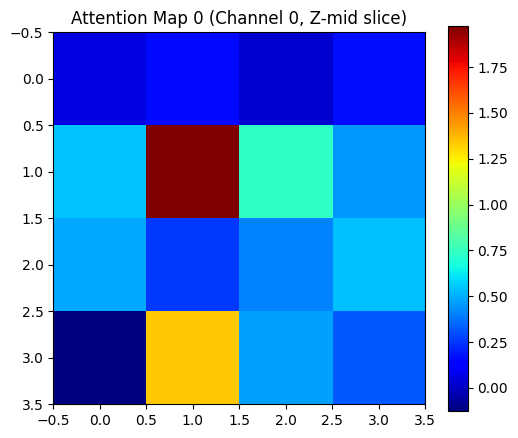

Attention map 1 shape: (1, 64, 4, 4, 4)


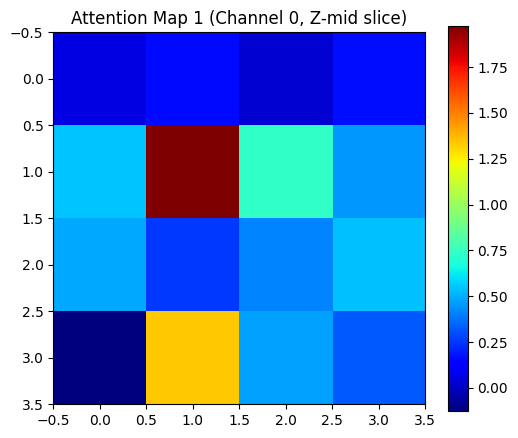

Attention map 2 shape: (1, 64, 4, 4, 4)


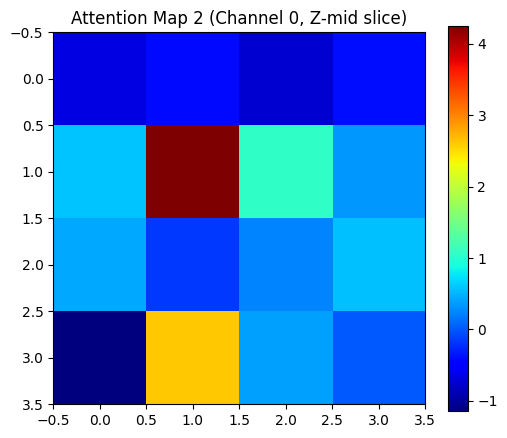

Attention map 3 shape: (1, 64, 4, 4, 4)


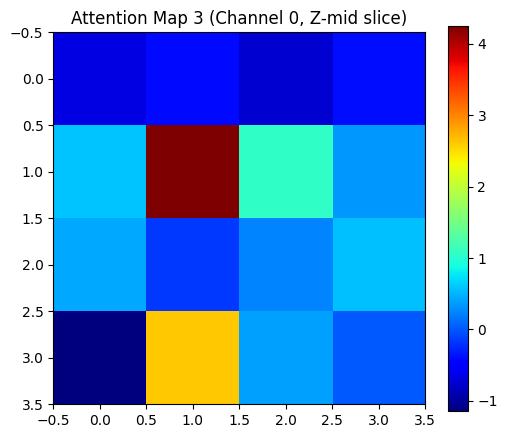

Attention map 4 shape: (1, 64, 4, 4, 4)


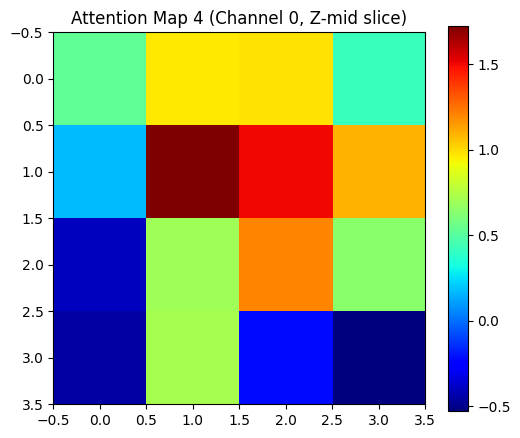

Attention map 5 shape: (1, 64, 4, 4, 4)


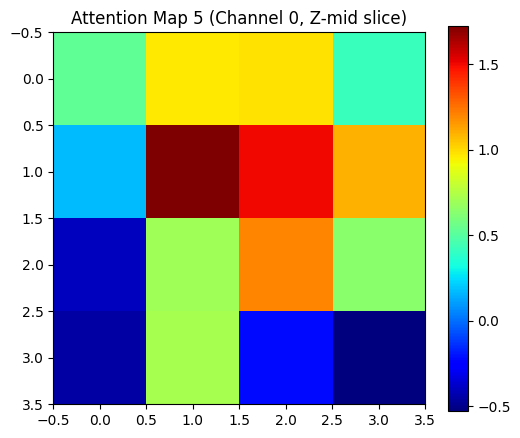

Attention map 6 shape: (1, 64, 4, 4, 4)


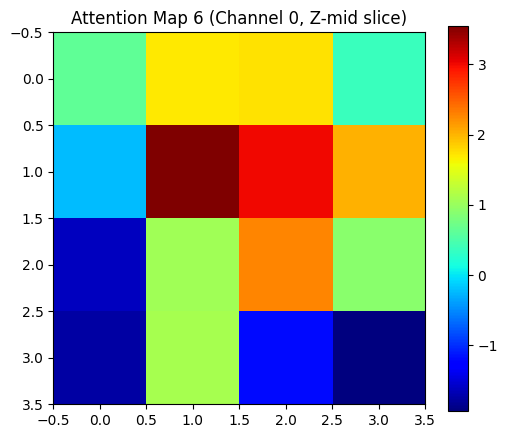

Attention map 7 shape: (1, 64, 4, 4, 4)


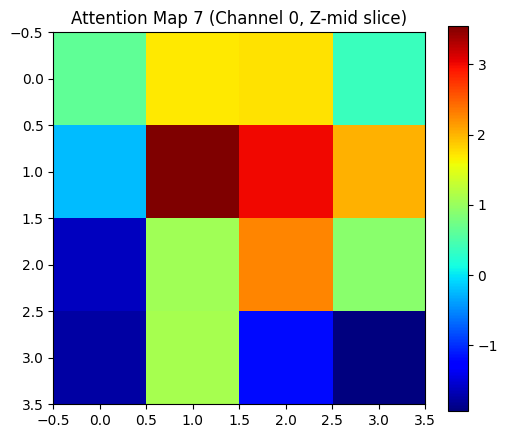

Attention map 8 shape: (1, 64, 4, 4, 4)


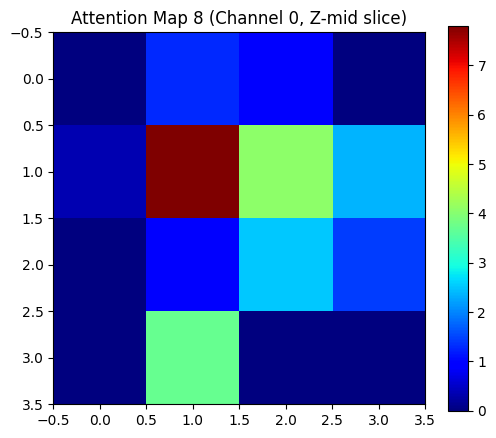

Attention map 9 shape: (1, 1, 4, 4, 4)


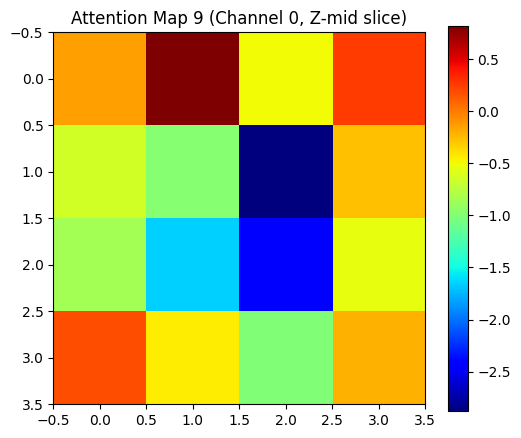

Attention map 10 shape: (1, 1, 4, 4, 4)


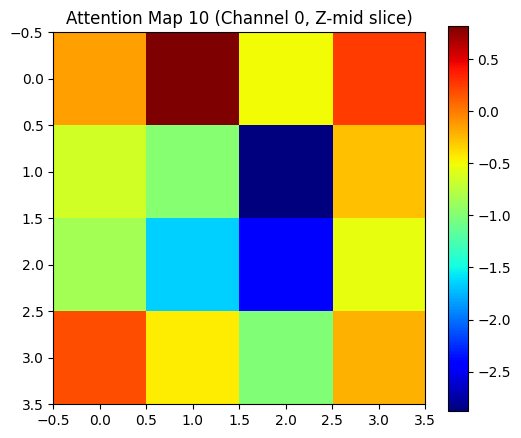

Attention map 11 shape: (1, 1, 4, 4, 4)


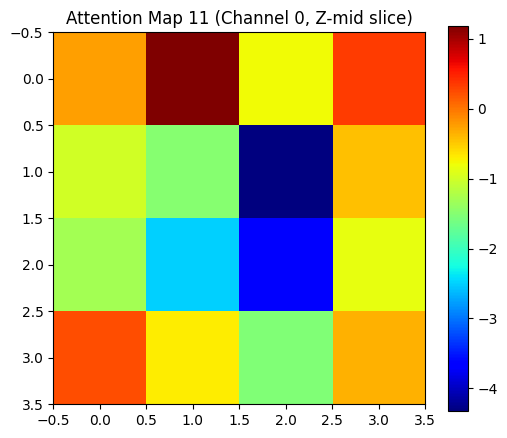

Attention map 12 shape: (1, 1, 4, 4, 4)


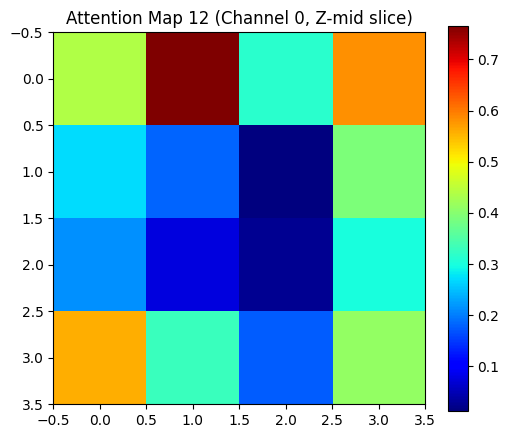

Attention map 13 shape: (1, 1, 4, 4, 4)


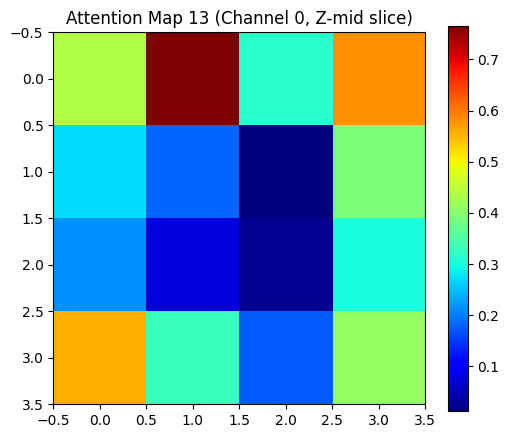

Attention map 14 shape: (1, 128, 4, 4, 4)


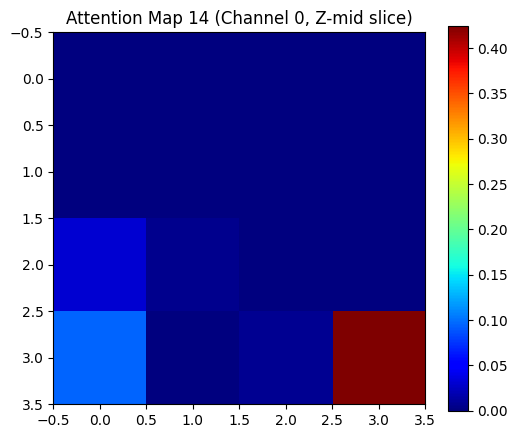

Attention map 15 shape: (1, 32, 8, 8, 8)


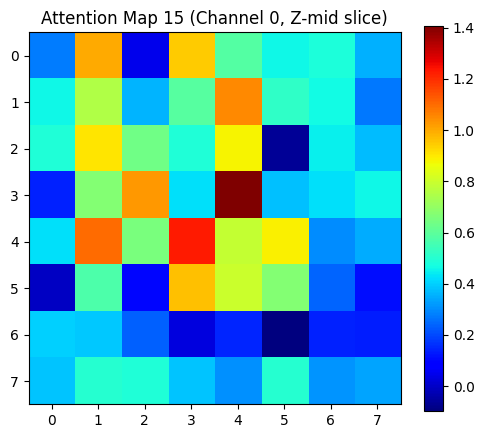

Attention map 16 shape: (1, 32, 8, 8, 8)


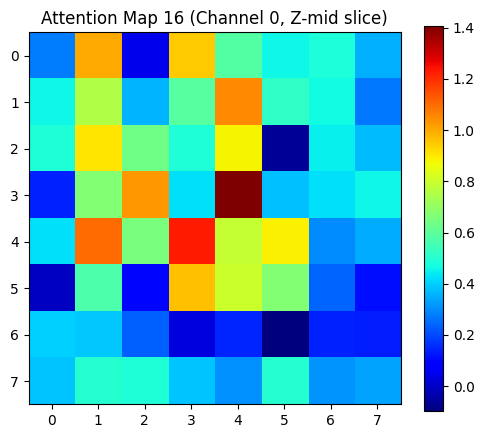

Attention map 17 shape: (1, 32, 8, 8, 8)


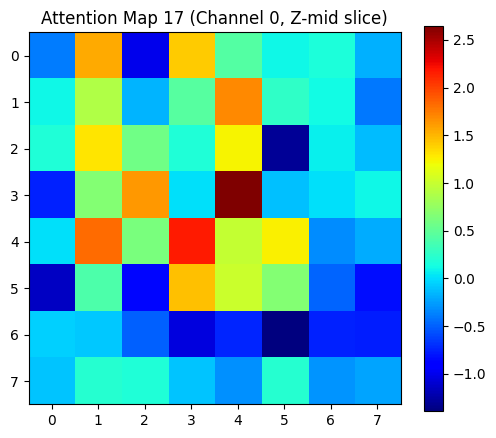

Attention map 18 shape: (1, 32, 8, 8, 8)


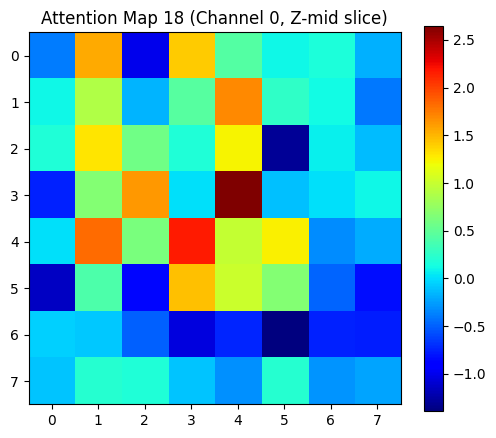

Attention map 19 shape: (1, 32, 8, 8, 8)


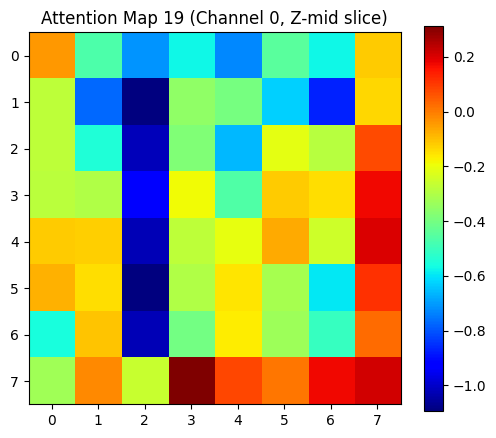

Attention map 20 shape: (1, 32, 8, 8, 8)


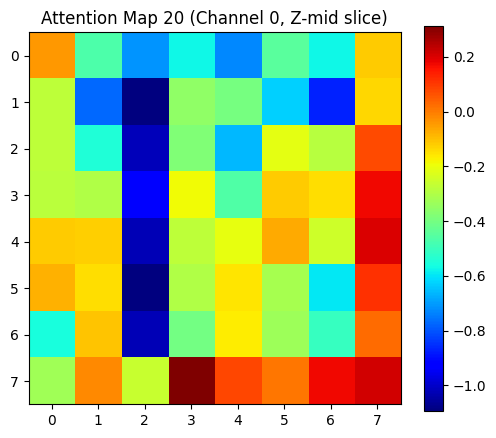

Attention map 21 shape: (1, 32, 8, 8, 8)


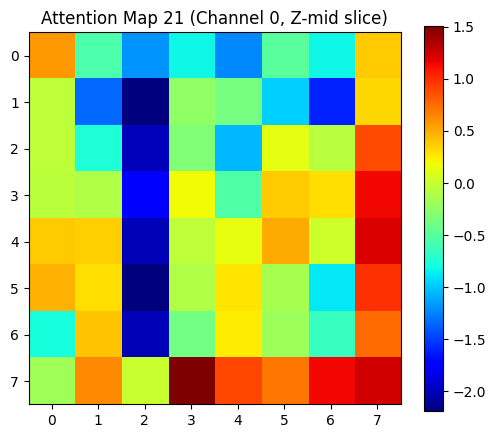

Attention map 22 shape: (1, 32, 8, 8, 8)


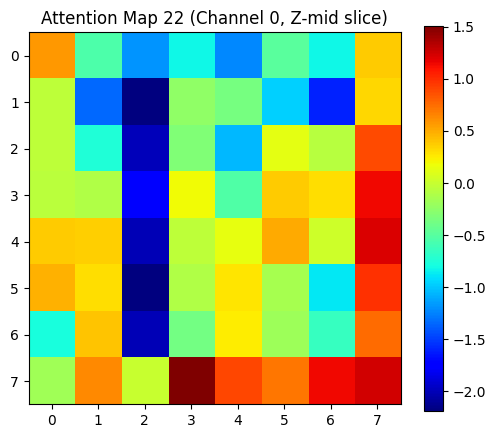

Attention map 23 shape: (1, 32, 8, 8, 8)


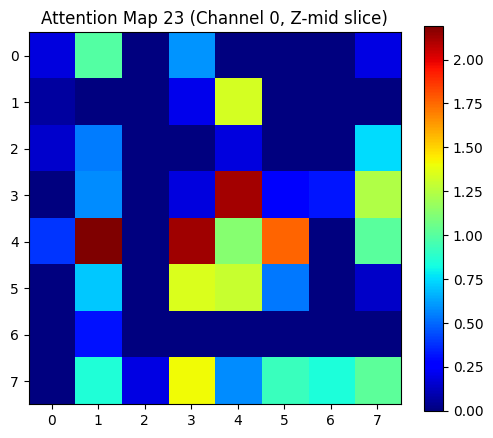

Attention map 24 shape: (1, 1, 8, 8, 8)


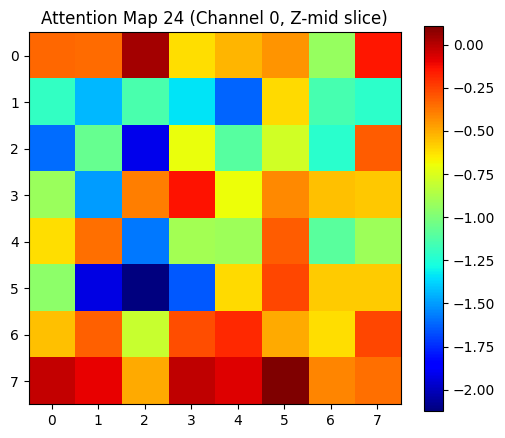

Attention map 25 shape: (1, 1, 8, 8, 8)


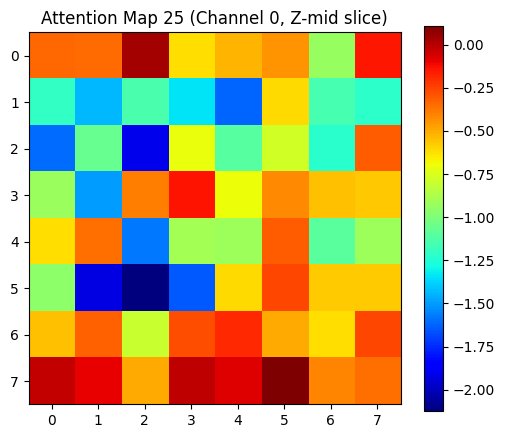

Attention map 26 shape: (1, 1, 8, 8, 8)


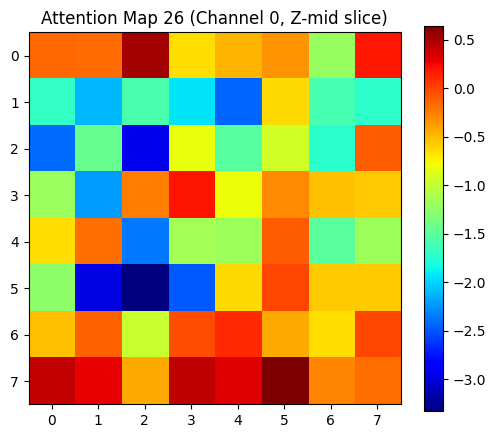

Attention map 27 shape: (1, 1, 8, 8, 8)


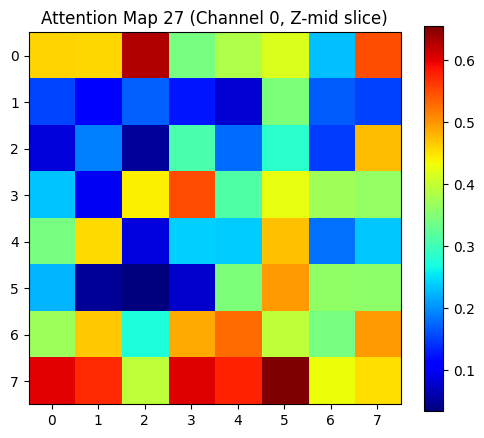

Attention map 28 shape: (1, 1, 8, 8, 8)


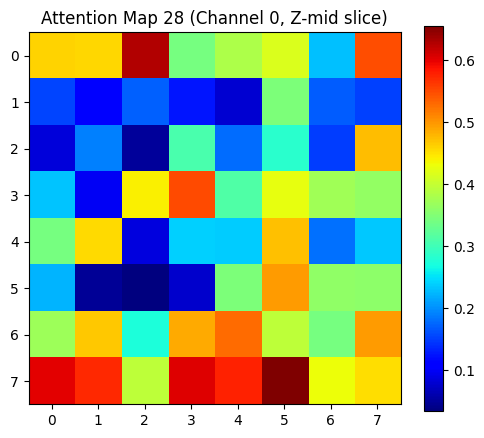

Attention map 29 shape: (1, 64, 8, 8, 8)


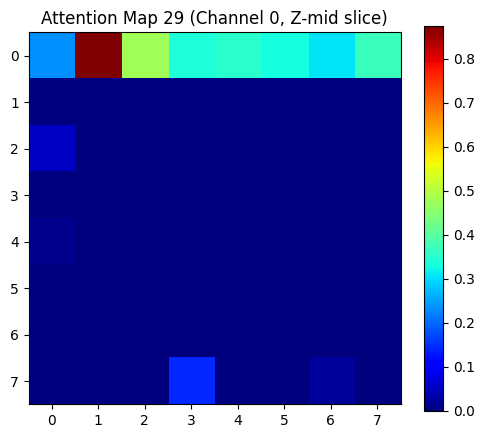

Attention map 30 shape: (1, 16, 16, 16, 16)


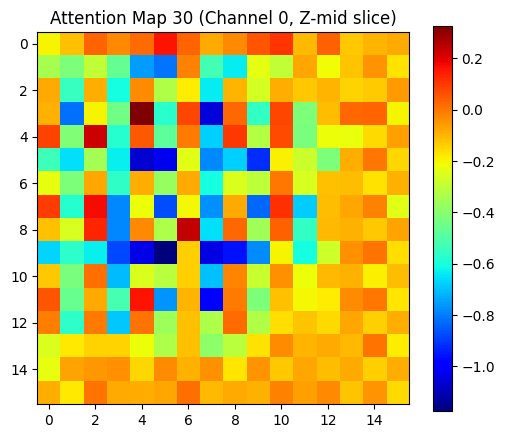

Attention map 31 shape: (1, 16, 16, 16, 16)


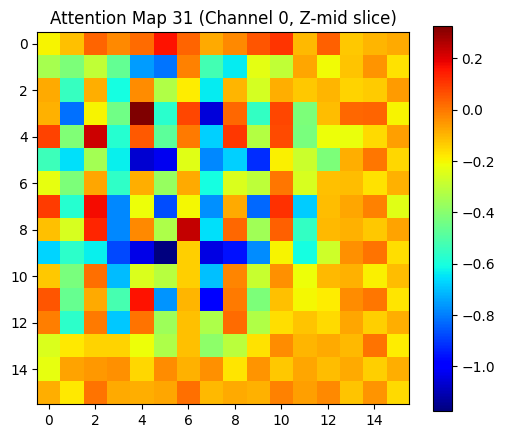

Attention map 32 shape: (1, 16, 16, 16, 16)


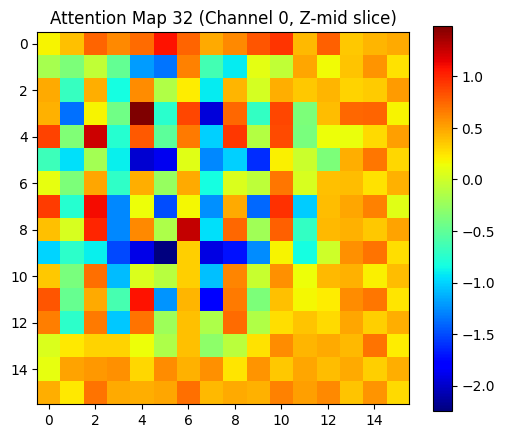

Attention map 33 shape: (1, 16, 16, 16, 16)


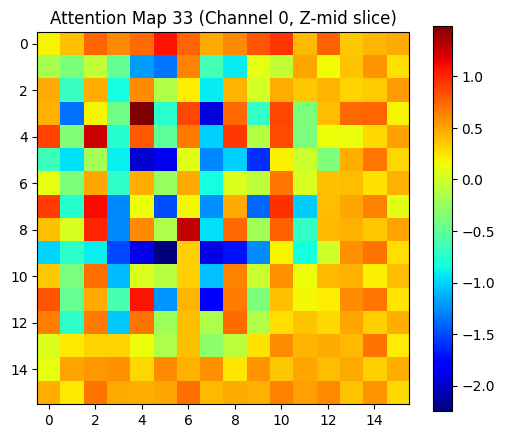

Attention map 34 shape: (1, 16, 16, 16, 16)


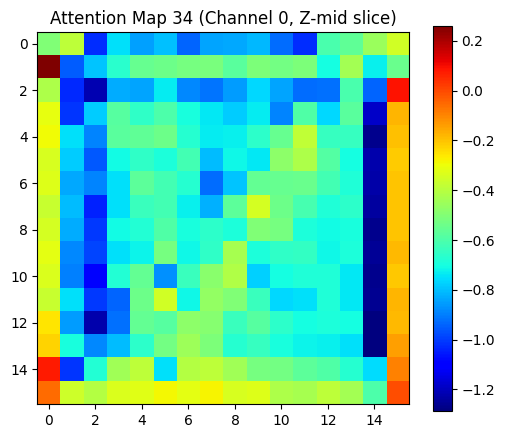

Attention map 35 shape: (1, 16, 16, 16, 16)


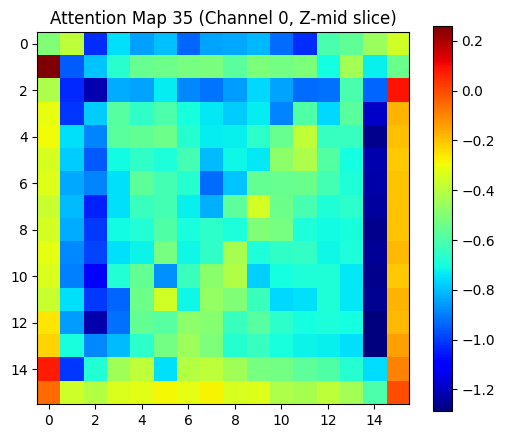

Attention map 36 shape: (1, 16, 16, 16, 16)


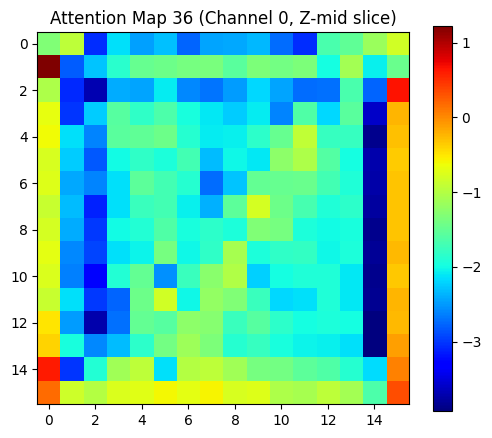

Attention map 37 shape: (1, 16, 16, 16, 16)


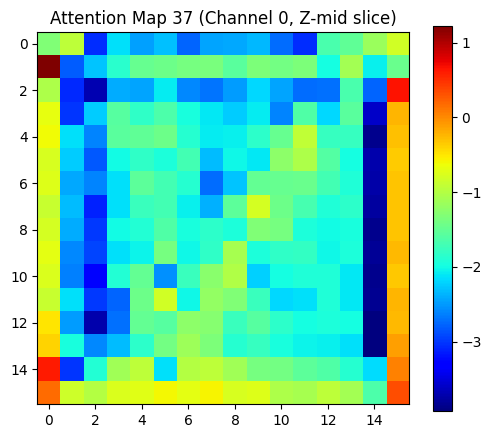

Attention map 38 shape: (1, 16, 16, 16, 16)


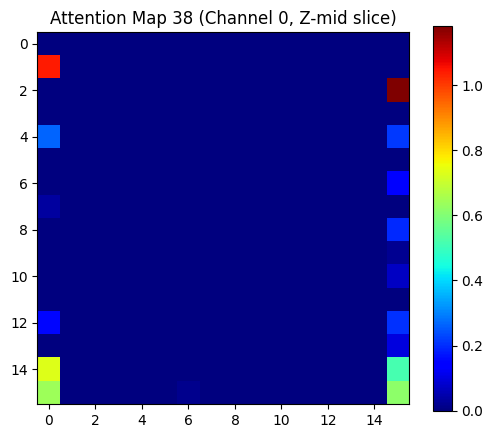

Attention map 39 shape: (1, 1, 16, 16, 16)


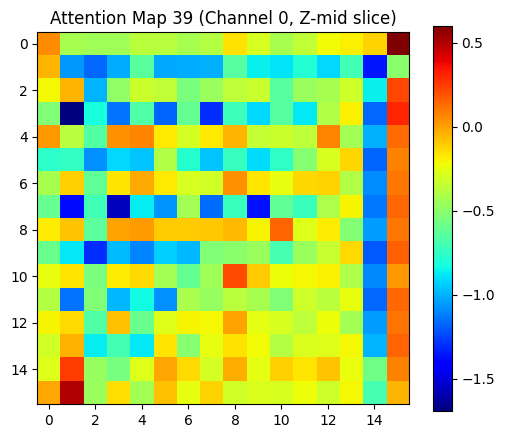

Attention map 40 shape: (1, 1, 16, 16, 16)


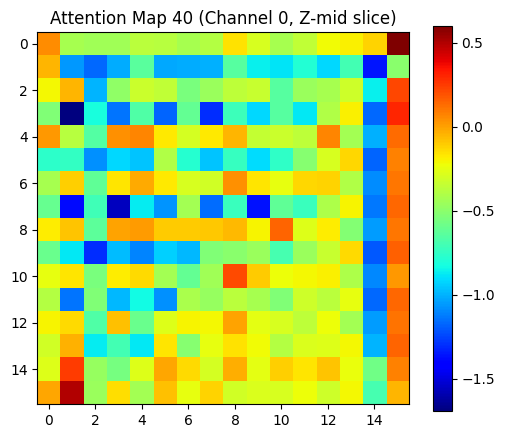

Attention map 41 shape: (1, 1, 16, 16, 16)


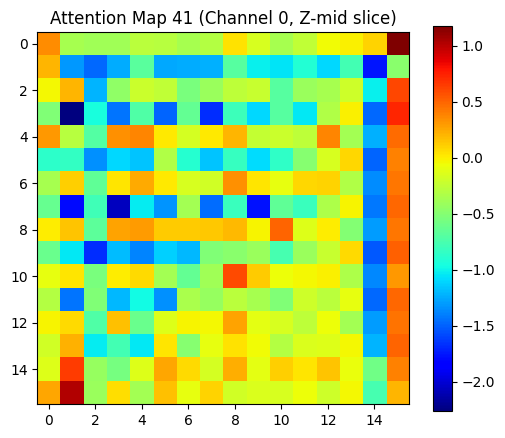

Attention map 42 shape: (1, 1, 16, 16, 16)


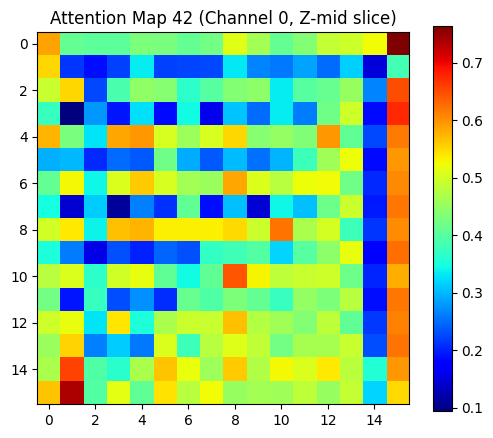

Attention map 43 shape: (1, 1, 16, 16, 16)


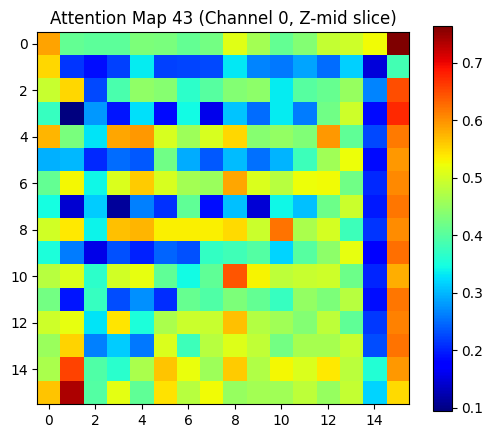

Attention map 44 shape: (1, 32, 16, 16, 16)


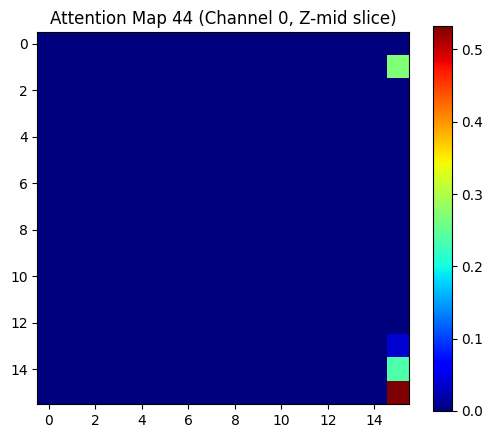

Attention map 45 shape: (1, 8, 32, 32, 32)


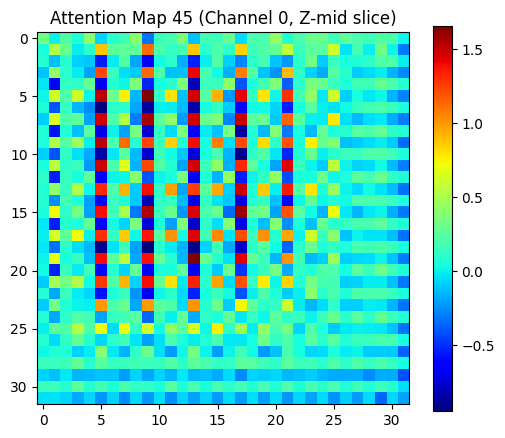

Attention map 46 shape: (1, 8, 32, 32, 32)


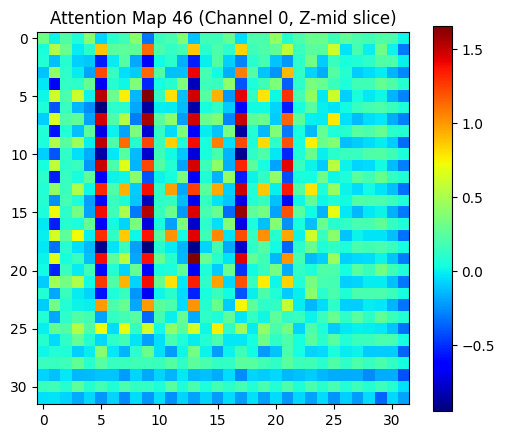

Attention map 47 shape: (1, 8, 32, 32, 32)


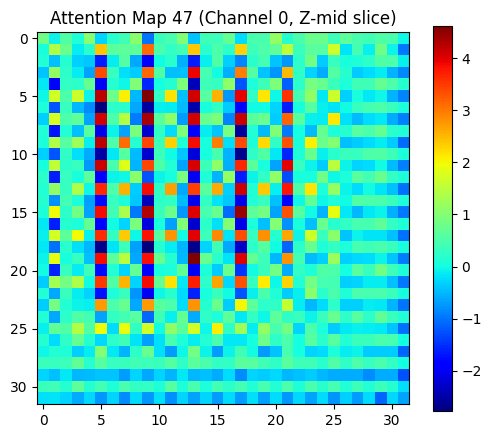

Attention map 48 shape: (1, 8, 32, 32, 32)


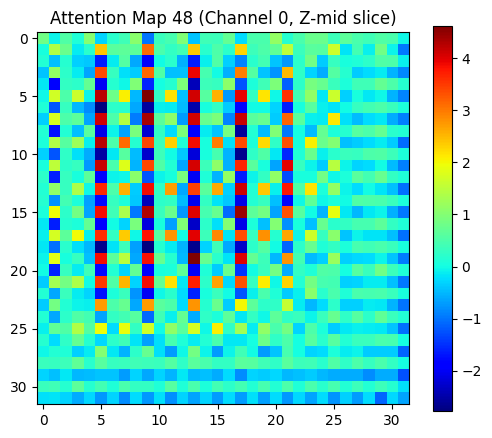

Attention map 49 shape: (1, 8, 32, 32, 32)


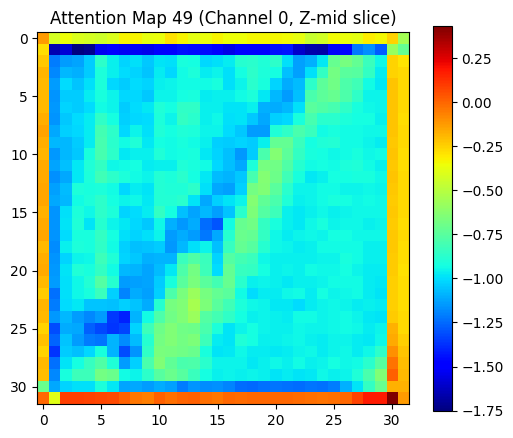

Attention map 50 shape: (1, 8, 32, 32, 32)


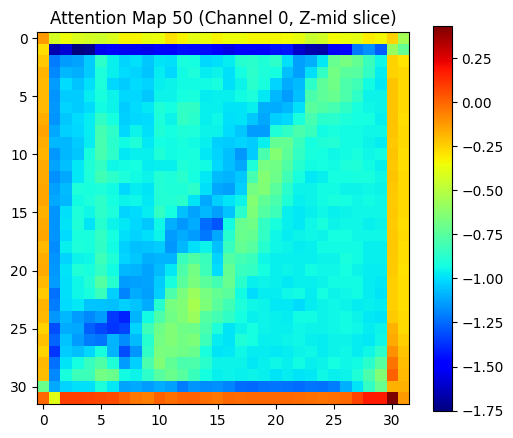

Attention map 51 shape: (1, 8, 32, 32, 32)


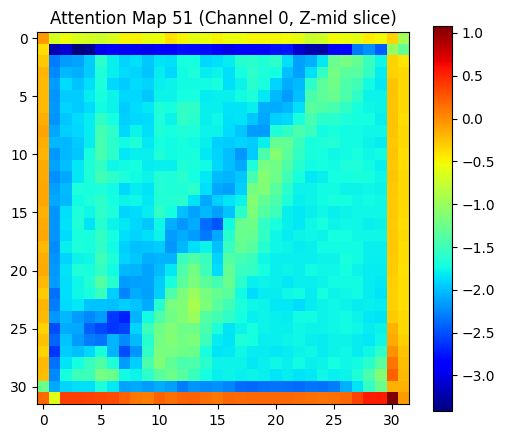

Attention map 52 shape: (1, 8, 32, 32, 32)


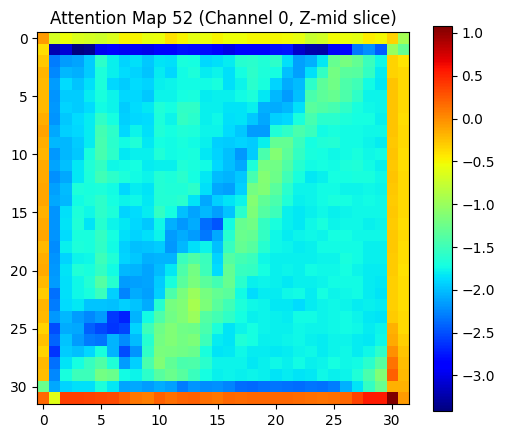

Attention map 53 shape: (1, 8, 32, 32, 32)


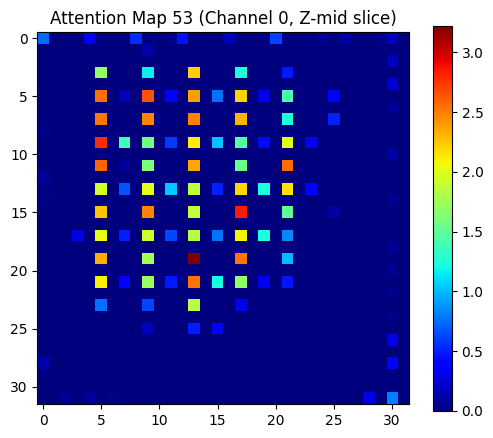

Attention map 54 shape: (1, 1, 32, 32, 32)


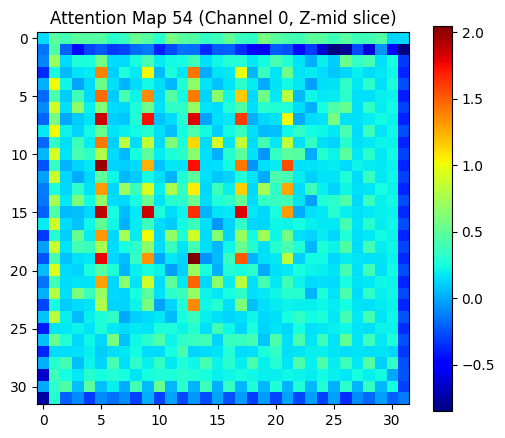

Attention map 55 shape: (1, 1, 32, 32, 32)


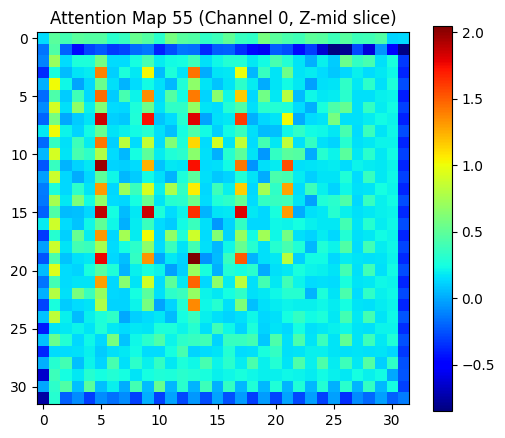

Attention map 56 shape: (1, 1, 32, 32, 32)


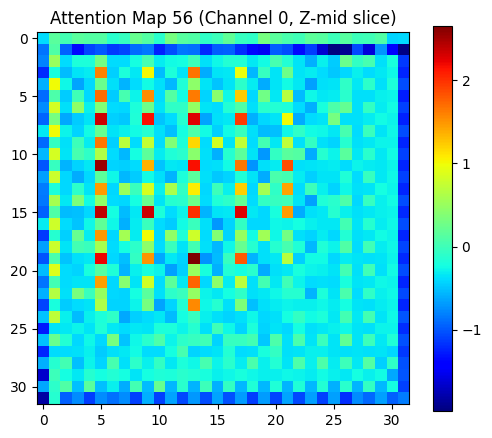

Attention map 57 shape: (1, 1, 32, 32, 32)


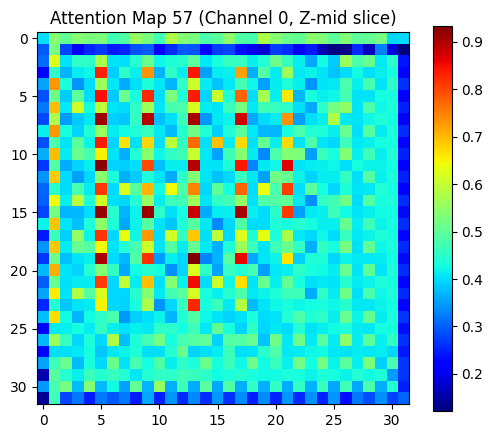

Attention map 58 shape: (1, 1, 32, 32, 32)


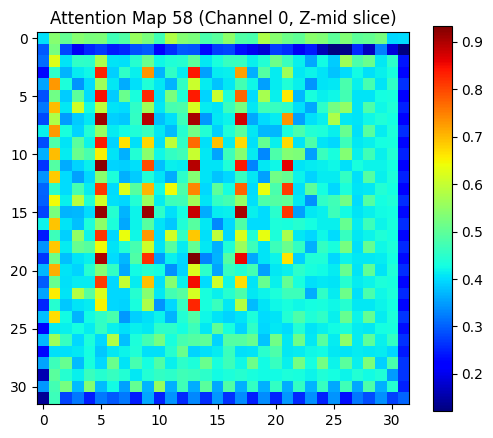

Attention map 59 shape: (1, 16, 32, 32, 32)


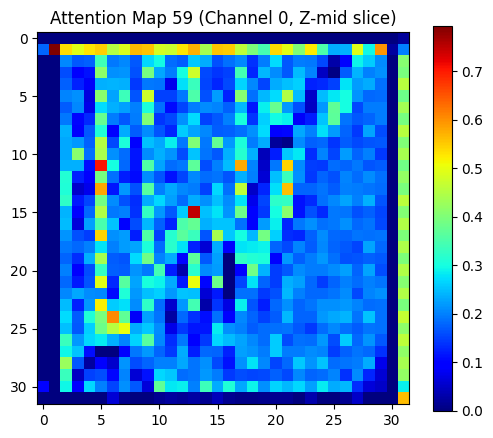

In [31]:
import matplotlib.pyplot as plt

# A list to store attention outputs
attention_maps = []

def hook_fn(module, input, output):
    """
    This function is called every time the hooked module does a forward pass.
    We'll append the attention map to our global list so we can visualize it.
    """
    # TODO: Append the module's output to the attention_maps list (convert to CPU first)
    attention_maps.append(output.detach().cpu())

# In AttentionUnet, attention is in the up_sample modules
# The attention gate outputs are part of the up_sample modules
for name, submodule in model.named_modules():
    # TODO: Identify attention modules and register a forward hook
    if 'att' in name.lower() and hasattr(submodule, 'forward'):
        print(f"Added hook to: {name}")
        submodule.register_forward_hook(hook_fn) # Register forward hook here

# Run a forward pass on one batch from val_loader
model.eval()
attention_maps.clear()

# TODO: Retrieve a validation sample from val_loader and move it to the correct device
val_sample = next(iter(val_loader))  # Get a single batch
val_inputs = val_sample["image"].to(device)

with torch.no_grad():
    # TODO: Run inference on the validation inputs
    _ = model(val_inputs)  # Run inference to capture attention maps

print(f"Captured {len(attention_maps)} attention maps")

# Example: Visualize the first captured attention for the first item in the batch
if attention_maps:
    for i, attn_map in enumerate(attention_maps):
        # Print shape to understand the structure
        print(f"Attention map {i} shape: {attn_map.shape}")

        # TODO: Extract and visualize a meaningful slice of the attention map
        # Hint: If 5D tensor [batch, channels, D, H, W], pick a middle Z slice
        if len(attn_map.shape) == 5:
            first_map = attn_map[0, 0]  # Extract first batch, first channel
            z_mid = first_map.shape[0] // 2  # Middle Z slice
            slice_2d = first_map[z_mid]  # Extract 2D slice

            plt.figure(figsize=(6, 5))
            plt.title(f"Attention Map {i} (Channel 0, Z-mid slice)")
            plt.imshow(slice_2d, cmap="jet")
            plt.colorbar()
            plt.show()
        elif len(attn_map.shape) == 4:
            # TODO: Handle the case where the attention map is 4D [batch, channels, H, W]
            first_map = attn_map[0, 0]  # Extract first batch, first channel

            plt.figure(figsize=(6, 5))
            plt.title(f"Attention Map {i} (Channel 0)")
            plt.imshow(first_map, cmap="jet")
            plt.colorbar()
            plt.show()
else:
    print("No attention maps were captured. Let's try a different approach.")

    # Alternative approach: Look at the structure of the model
    print("\nModel structure:")
    for name, module in model.named_modules():
        print(f"{name}: {type(module).__name__}")

    # TODO: Try to find and register hooks for attention-related layers another way
    attention_maps.clear()

    for name, module in model.named_modules():
        if "up" in name and hasattr(module, 'forward'):
            print(f"Adding hook to up module: {name}")
            module.register_forward_hook(hook_fn)  # Register forward hook here

    # Run inference again
    with torch.no_grad():
        # TODO: Run the model again to capture feature maps
        _ = model(val_inputs)

    print(f"Second attempt captured {len(attention_maps)} feature maps")

    # TODO: Extract and visualize the first few feature maps
    if attention_maps:
        for i, feat_map in enumerate(attention_maps[:3]):  # Show first 3 only
            print(f"Feature map {i} shape: {feat_map.shape}")

            if len(feat_map.shape) == 5:
                first_map = feat_map[0, 0]  # Extract first batch, first channel
                z_mid = first_map.shape[0] // 2  # Compute middle Z slice
                slice_2d = first_map[z_mid]  # Extract the 2D slice

                plt.figure(figsize=(6, 5))
                plt.title(f"Feature Map {i} (Channel 0, Z-mid slice)")
                plt.imshow(slice_2d, cmap="jet")
                plt.colorbar()
                plt.show()


### Note:
The above training loop is just 5 epochs, which is typically not enough for good performance. But it demonstrates the pipeline. Feel free to edit and test it out beyond the scope of the lab work.
And that's it! We combined a SHAP example for a tabular problem with an Attention UNet example for 3D medical imaging segmentation.